# Plotting ML Models trends

Try to group the model per "category" this is pretty subjective, but might help visualizing trends.


In [1]:
import pandas as pd
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from pprint import pprint as pp 
from utils.utils import print_pretty_df, wrap_label
from utils.metadata import plot_colors, general_task_colors

# Quick ANSI color code shortcuts
r = "\033[31m"
y = "\033[33m"
g = "\033[32m"
b = "\033[34m"
e = "\033[0m"

pickleName = "all_datapoints.pkl"
datapointsDfPath = Path("..") / "data" / "Dataframes" / pickleName
datapointsDf = pd.read_pickle(datapointsDfPath)

versionTag = "_v3"
figureName = "model_per_year" + versionTag
saveFormat = "pdf"
saveFigurePath = Path("..") / "data" / "Figures" / "RQ_figures" / f"{figureName}.{saveFormat}"

In [2]:
def add_model_group_column(df):
    """
    Adds a 'Model Group' column to the dataframe based on similarities in model names.

    Args:
        df (DataFrame): The original dataframe containing 'Model', 'Equivalent model', and 'Backbone' columns.

    Returns:
        DataFrame: The dataframe with the new 'Model Group' column added.
    """
    # Define the grouping keywords and their corresponding group labels
    model_group_map = {
        # Deep Learning
        'ALEXNET': 'AlexNet',
        'YOLO': 'YOLO',
        'SSD': 'SSD',
        'VGG': 'VGG',
        'RESNET': 'ResNet',
        'GHOSTNET': 'GhostNet',
        'U-NET': 'U-Net',
        'MOBILENET': 'Custom CNN', # to avoid being identify as "LeNet"
        # 'FPN': 'Custom CNN',
        # 'SQUEEZENET': 'Custom CNN',
        # 'ENET': 'Custom CNN',
        # 'ESPNET': 'Custom CNN',
        'LENET': 'LeNet',

        # Shallow Neural Networks
        'MLP': 'Shallow NN',
        'DEEP BELIEF NETWORK': 'Shallow NN',
        'WEIGHTLESS NEURAL SYSTEMS': 'Shallow NN',

        # Graph Neural Networks
        'GNN': 'GNN',

        # Classic Machine Learning
        'SVM': 'Classic ML',
        'DECISION TREE': 'Classic ML',
        'Fuzzy ARTMAP': 'Classic ML',
        'LPDBL': 'Classic ML',
        'ROLLER DUNG BETTLE CLUSTERING': 'Classic ML',
        # Weird and mixed models
        'CAL-SC2S': 'Classic ML',
        'CAG-SC2S': 'Classic ML',

        # Not enough information
        'CNN': 'Custom CNN',
    }

    # Function to assign model group based on keywords in 'Model', 'Equivalent model', and 'Backbone'
    def assign_model_group(row):
        # Combine the values from the three columns
        combined_info = f"{row['Model']} {row['Equivalent model']} {row['Backbone']}".upper()
        for keyword, group_label in model_group_map.items():
            if keyword.upper() in combined_info:
                return group_label
        return 'Other Models'  # Default group if no keywords match

    # Apply the function to the dataframe
    df['Model Group'] = df.apply(assign_model_group, axis=1)
    return df

# Example usage:
# Assuming 'allModelsDF' is your DataFrame
allModelsDF = add_model_group_column(datapointsDf)
print_pretty_df(datapointsDf[["Model Group", "Model", "Equivalent model", "Backbone", "BBT Citation Key"]].sort_values(by="Model Group"))

+----+-------------+-------------------------------+------------------+----------------+-------------------------------------------------------+
|    | Model Group |             Model             | Equivalent model |    Backbone    |                   BBT Citation Key                    |
+----+-------------+-------------------------------+------------------+----------------+-------------------------------------------------------+
| 22 |   AlexNet   |          AlexNetLite          |     AlexNet      |    AlexNet     |         nerisFPGABasedImplementationCNN2022a          |
| 65 | Classic ML  | Roller Dung Bettle Clustering |        ML        |                |             ratnakumarHighSpeedRoller2021             |
| 56 | Classic ML  |           CAG-SC2S            |        ML        |                |              gyaneshwarRealtimeSCSUP2022              |
| 58 | Classic ML  |              SVM              |        ML        |                |              gyaneshwarRealtimeSCSUP2022 

In [3]:
df = datapointsDf[datapointsDf["Model Group"] == "U-Net"]
print(datapointsDf["Model Group"].value_counts())
print(f"Total number of models: {len(datapointsDf)}")
print(len(datapointsDf))
print_pretty_df(df)
# 8 Classic ML models
# 4 Shallow NN models
# 3 GNN models
# 31 CNN: 3 LeNet + 1 AlexNet + 4 VGG + 4 ResNet + 19 Custom CNN
# 14 YOLO + 4 SSD

Model Group
Custom CNN    18
YOLO          14
Classic ML     9
Shallow NN     4
ResNet         4
SSD            4
VGG            4
LeNet          3
GNN            3
U-Net          2
AlexNet        1
Name: count, dtype: int64
Total number of models: 66
66
+----+--------------------------------------------+---------------------+------------------+------------+----------+------------------------------------+----------------+----------------+----------------------------------+------------------+------------------+---------+----------+------------+-----------+------------+-------------------+-----------+------------+----------------+----------+-----------+------------------+-----------------------------------+------------+----------+----------+---------------------+-------------+
|    |              BBT Citation Key              |        Model        | Equivalent model |  Backbone  | Modality |              Dataset               |      Task      |  Application   |              Board        

Saving figure to ..\data\Figures\RQ_figures\model_per_year_v3.pdf.


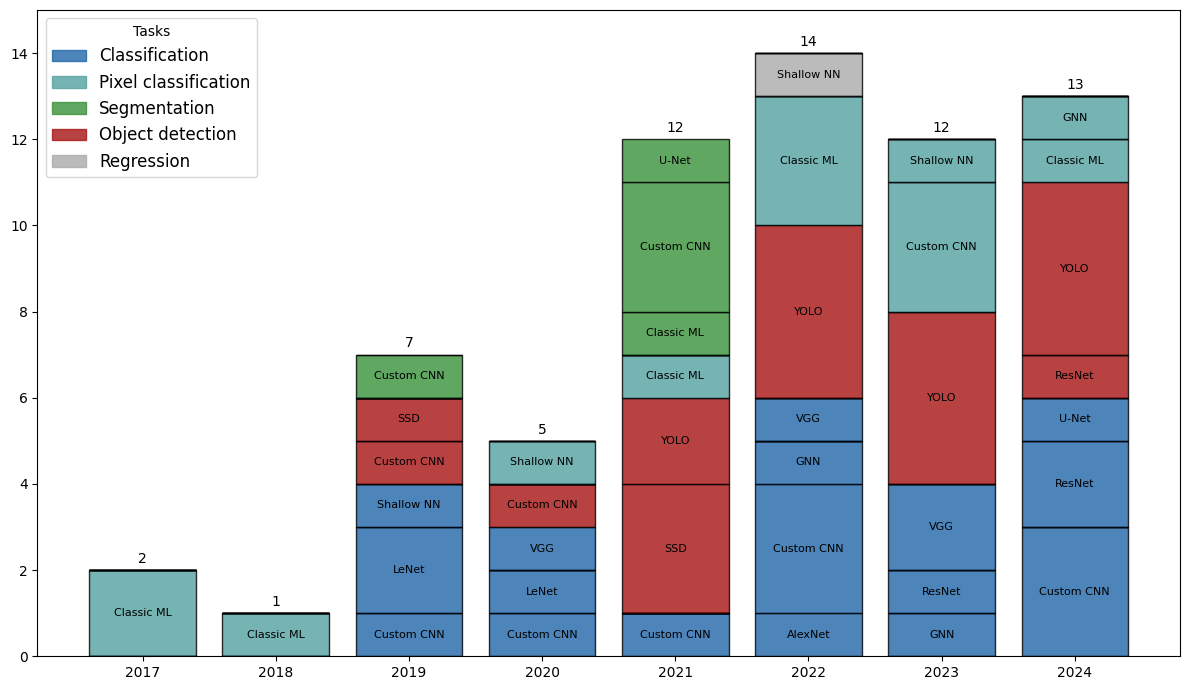

In [4]:
def plot_model_groups_by_year(DataFrame):
    """
    Plot a stacked bar chart showing the number of model groups per publication year.
    Each bar represents a publication year, divided into segments for each Model Group.
    The color of each segment corresponds to the Task.
    """

    # Copy the DataFrame
    DF = DataFrame.copy()
    
    # Force the order of Tasks
    TaskOrder = ['Classification', 'Pixel classification', 'Segmentation', 'Object detection', 'Regression']
    
    # Group data by 'Publication year', 'Task', and 'Model Group', count occurrences
    Counts = DF.groupby(['Publication year', 'Task', 'Model Group']).size().reset_index(name='Count')

    # Remove entries with zero counts
    Counts = Counts[Counts['Count'] > 0]

    # Assign colors to Tasks
    cmap = plt.get_cmap('Set3')
    TaskColors = general_task_colors #{task: cmap(i / len(TaskOrder)) for i, task in enumerate(TaskOrder)}
    
    # Pivot data
    PivotDF = Counts.pivot_table(
        index='Publication year',
        columns=['Task', 'Model Group'],
        values='Count',
        fill_value=0
    )

    # Ensure Tasks are in the specified order
    PivotDF = PivotDF.reindex(columns=PivotDF.columns.reindex(TaskOrder, level=0)[0], fill_value=0)
    
    # Sort columns by Task and Model Group
    PivotDF = PivotDF.sort_index(axis=1, level=[0,1], sort_remaining=False)

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 7))

    Bottom = np.zeros(len(PivotDF))
    X = PivotDF.index.astype(str)
    BarWidth = 0.8

    # Calculate total counts per publication year
    TotalCounts = PivotDF.sum(axis=1)

    for (Task, ModelGroup) in PivotDF.columns:
        Counts = PivotDF[(Task, ModelGroup)].values
        if np.all(Counts == 0):
            continue  # Skip if all counts are zero
        Color = TaskColors.get(Task, '#333333')
        Bars = ax.bar(
            X,
            Counts,
            alpha=0.8,
            bottom=Bottom,
            color=Color,
            edgecolor='black',
            width=BarWidth
        )
        # Add model group name as label within sub-bar if count > 0
        Labels = [ModelGroup if count > 0 else '' for count in Counts]
        ax.bar_label(Bars, labels=Labels, label_type='center', fontsize=8)
        Bottom += Counts

    # Add total count labels on top of each yearly bar
    for i, total in enumerate(TotalCounts):
        ax.text(i, TotalCounts.iloc[i] + 0.1, f"{int(TotalCounts.iloc[i])}", ha='center', va='bottom')

    # Create legend for Tasks
    Handles = [mpatches.Patch(color=TaskColors[task], alpha=0.8, label=task) for task in TaskOrder]
    ax.legend(handles=Handles, title='Tasks', loc='upper left', fontsize=12)

    # ax.set_title('Model Groups by Publication Year')
    # ax.set_xlabel('Publication Year')
    # ax.set_ylabel('Count')
    plt.ylim(0, 15)
    plt.tight_layout()

    # Save the figure
    print(f"Saving figure to {b}{saveFigurePath}{e}.")
    plt.savefig(saveFigurePath, format=saveFormat)
    
    plt.show()

# Example usage
plot_model_groups_by_year(allModelsDF[['Model Group', 'Publication year', 'Task']])